# Master's Thesis Analysis

Predicting discharge times of patients??

#### Author: Derek Lee

## Load Requisite Libraries and authenticate to local Postgres database

In [8]:
import pandas as pd
import psycopg2
import sqlalchemy
import time
import psutil
import numpy as np
import multiprocessing as mp


from sklearn.model_selection import train_test_split



In [9]:
# Check the number of cores and memory usage
num_cores = mp.cpu_count()
print("This kernel has ",num_cores,"cores and you can find the information regarding the memory usage:",psutil.virtual_memory())

This kernel has  8 cores and you can find the information regarding the memory usage: svmem(total=17179869184, available=6436990976, percent=62.5, used=8236359680, free=412962816, active=6027169792, inactive=5965406208, wired=2209189888)


In [10]:
%reload_ext sql
from sqlalchemy import create_engine

In [11]:
import json
json_file = open("secrets.json")
variables = json.load(json_file)
json_file.close()

import os
os.environ['POSTGRES_USERNAME'] = variables['POSTGRES_USERNAME']
os.environ['POSTGRES_PASSWORD'] = variables['POSTGRES_PASSWORD']
os.environ['POSTGRES_ADDRESS'] = variables['POSTGRES_ADDRESS']
os.environ['POSTGRES_PORT'] = variables['POSTGRES_PORT']
os.environ['POSTGRES_DBNAME'] = variables['POSTGRES_DBNAME']

In [12]:
# A long string that contains the necessary Postgres login information 
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=os.getenv('POSTGRES_USERNAME'),
                        password=os.getenv('POSTGRES_PASSWORD'),
                        ipaddress=os.getenv('POSTGRES_ADDRESS'),
                        port=os.getenv('POSTGRES_PORT'),
                        dbname=os.getenv('POSTGRES_DBNAME'))) 
# Create the connection 
engine = create_engine(postgres_str)

-------------------------------------

### Note: Large Dataset:
Running below will take about 5 minutes because it's a dataset with approx 20 million rows

Update: cleaned the data further in sql, reducine our dataset to 3328 rows for 785 unique patients and taking 14 seconds to upload. Seems like tons of duplicate rows, which we removed to get a dataset of 3300 rows ish and 785 unique patients

In [13]:
# Use "postgres -D /usr/local/var/postgres" if the postgres database ever is shut down incorrectly therefore you can't connect
#Or you might need to start the server in terminal as below:
# /usr/local/opt/postgresql@12/bin/pg_ctl -D /usr/local/var/postgres start

from datetime import datetime 

start_time = datetime.now() 

import time

data = pd.read_sql('''SELECT * FROM public."thesis_data";''', con=engine)


# data = pd.read_sql('''SELECT * FROM public."thesis_data";''', con=engine, chunksize=1000000)


print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:08.990077


In [14]:
pd.set_option('display.max_columns', None)
data.columns


Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code'],

`admittime` = time admitted to hospital  
`dischtime` = time discharged from hospital  
`edregtime` = time registered in ED  
`edouttime` = time discharge from ED    
`createtime` = time and date that the call out was initiated  
`updatetime` = last time at which the call out event was updated  
`acknowledgetime` = time at which the call out was first acknowledged  
`outcometime` = time at which the CALLOUT_OUTCOME occurred  
`intime` = provides the date and time the patient was transferred into the ICU  
`outtime` = provides the date and time the patient was transferred out of the ICU  
`los` = length of stay for the patient for the given ICU stay, which may include one or more ICU units. The length of stay is measured in fractional days.


Most variables are categorical, some being text while others are number codes. For the times, we can convert into cyclical time features https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/ so it becomes continuous or just calculate the intervals between time events and extracting it in hours or some other desired time format.

In [15]:
data.shape

(4151, 60)

#### Creating the target variable:

Our target variable is the time it takes from when a person is ready for discharge to when they are actually discharged. This needs to be engineered from our data.

In [16]:
# data['timediff'] = data['outtime']-data['intime']

data['timediff'] = data['outcometime']-data['acknowledgetime']

data['timediff_hours'] = (data['outcometime'].sub(data['acknowledgetime']).dt.seconds/60/60).round(1)



In [17]:
data[data['timediff'].isna()==False] # success!

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
14,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,ICU,99253,99253,None,Evaluation and management,Consultations,None,2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,4.9
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,4.9
16,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,1,527,1 days 08:29:33,8.5
17,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE),2190-01-05 00:37:59,None,SURG,1,527,1 days 08:29:33,8.5
18,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,2,5122,1 days 08:29:33,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4146,F,2055-07-17,2144-01-23,NaT,2144-01-23,1,58917,99814,186518,2142-02-16 16:33:00,2142-02-21 16:38:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,NaT,NaT,TRANSIENT ISCHEMIC ATTACK,0,1,1

**Creating other variables**

In [18]:
# to do: convert times into intervals in hours (admittime to dischtime, edregtime to edouttime, intime to outtime)
# new columns and then dummify: month of death (see deathtime code when graphed)
# new columns: age when they arrived in hospital

data['deathmonth'] = data['dod'].dt.month
data['admit2disch_hours'] = (data['dischtime'].sub(data['admittime']).dt.seconds/60/60).round(1)
data['edreg2edout_hours'] = (data['edouttime'].sub(data['edregtime']).dt.seconds/60/60).round(1)
data['in2out_hours'] = (data['outtime'].sub(data['intime']).dt.seconds/60/60).round(1)

data['age'] = data['admittime'].sub(data['dob']).astype('timedelta64[Y]').astype('int')
 




In [19]:
timediff_noNA = data[data['timediff'].isna()==False]
# timediff_noNA.drop_duplicates(subset=['subject_id','diagnosis'], keep='last')

In [20]:
min(timediff_noNA.timediff_hours)
max(timediff_noNA.timediff_hours)
(timediff_noNA.timediff_hours).mean()

5.707173447537473

In [21]:
timediff_noNA.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

In [22]:
# Get the last of each sequence
timediff_noNA = timediff_noNA.groupby(['subject_id']).last()

Limiting each patient to only one row using their final procedure cuts down our dataset by a lot.

In [23]:
timediff_noNA.shape

(790, 66)

-----------------------------------------------------------------------

## Exploratory Data Analysis

##### Initial logic checks:

While we deduped the initial dataset and isolated it to the last procedure the patient had before discharge, we still have lots to do to inspect and clean our data.  

1) Look to see if data makes sense. Check if there are any patients where their date of death (dod) is before date of birth (dob), is edregtime before edouttime?

2) If there are any of the times that are out of order (besides date of birth), we can flag those as administrative errors  


In [24]:
# data.gender.unique()

from datetime import datetime, timedelta 
# truth = ((data.dod.dt.date-data.dob.dt.date)<timedelta(0))
# truth = ((data.edouttime.dt.date-data.edregtime.dt.date)<timedelta(0))
# truth = ((data.updatetime.dt.date-data.createtime.dt.date)<timedelta(0))
truth = ((timediff_noNA.outtime.dt.date-timediff_noNA.intime.dt.date)<timedelta(0))
truth.unique()



array([False])

If we have logical errors, we would see some negative values in the subtraction of the two dates and therefore the array would have `True` values.  

We do have issues with the years in the `dob` and `dod` variables corresponding to date of birth and date of death. We may have to discard these as there's no better wage to ascertain age.

In [25]:
timediff_noNA['dob'].head()

subject_id
286   2090-12-25
325   2132-06-06
423   2091-05-22
443   2088-11-09
485   2129-12-24
Name: dob, dtype: datetime64[ns]

In [26]:
# At this time 611 rows of data
timediff_noNA.shape

(790, 66)

In [27]:
timediff_noNA['marital_status'] = timediff_noNA['marital_status'].replace([None,'UNKNOWN (DEFAULT)'], 'UNKNOWN_MARITAL')
timediff_noNA['marital_status'] = timediff_noNA['marital_status'].replace(['WIDOWED', 'DIVORCED', 'SEPARATED'], "SINGLE")



timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['UNKNOWN/NOT SPECIFIED',
                                                                           'PATIENT DECLINED TO ANSWER',
                                                                          'UNABLE TO OBTAIN'], 'UNKNOWN_ETHNICITY')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['ASIAN - CHINESE'], 'ASIAN')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['HISPANIC OR LATINO',
                                                                           'HISPANIC/LATINO - GUATEMALAN',
                                                                           'HISPANIC/LATINO - PUERTO RICAN',
                                                                           'HISPANIC/LATINO - DOMINICAN',
                                                                          'WHITE - BRAZILIAN'], 'HISPANIC_LATINO')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['BLACK/AFRICAN AMERICAN',
                                                                          'BLACK/AFRICAN',
                                                                           'BLACK/CAPE VERDEAN'], 'BLACK')

timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['MULTI RACE ETHNICITY'],'MIXED_ETHNICITY')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['OTHER'],'OTHER_ETHNICITY')

timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['ASIAN', 'BLACK', 'OTHER_ETHNICITY',
       'HISPANIC_LATINO', 'ASIAN - VIETNAMESE', 'MIXED_ETHNICITY',
       'WHITE - OTHER EUROPEAN', 'AMERICAN INDIAN/ALASKA NATIVE',
       'PORTUGUESE', 'MIDDLE EASTERN'], "NONWHITE")

timediff_noNA['language'] = timediff_noNA['language'].replace([None],'UNKNOWN')

timediff_noNA['description'] = timediff_noNA['description'].replace([None],'NOT APPLICABLE')

# timediff_noNA['religion'] = timediff_noNA['religion'].replace('UNOBTAINABLE','NOT SPECIFIED')

timediff_noNA['gender'] = timediff_noNA['gender'].replace('F', 0)
timediff_noNA['gender'] = timediff_noNA['gender'].replace('M', 1)

In [28]:
timediff_noNA['religion'] = timediff_noNA['religion'].replace(['PROTESTANT QUAKER', 'OTHER', 'CATHOLIC',
       'EPISCOPALIAN', 'JEWISH', 'GREEK ORTHODOX', 'ROMANIAN EAST. ORTH',
       'CHRISTIAN SCIENTIST', 'BUDDHIST', 'UNITARIAN-UNIVERSALIST',
       "JEHOVAH'S WITNESS", 'MUSLIM', 'HINDU'], 1)

timediff_noNA['religion'] = timediff_noNA['religion'].replace(['UNOBTAINABLE', 'NOT SPECIFIED'], 0)

In [29]:
timediff_noNA['religion'].unique()

array([1, 0])

In [30]:
timediff_noNA['diagnosis_categories'] = timediff_noNA.loc[:,'diagnosis']

In [31]:
timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace([' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
                                                                            'ABDOMINAL ABSCESS',
                                                                            'ABSCESS OF GALLSTONES/SDA',
                                                                            "BARRETT'S ESOPHAGUS/SDA",
                                                                          'ABDOMINAL INFECTION',
                                                                           'ABDOMINAL PAIN',
                                                                           'ACUTE CHOLECYSTITIS',
                                                                            'ADRENAL MASS/SDA',
                                                                           'BOWEL OBSTRUCTION',
                                                                           'BOWEL OBSTRUCTION;FAILURE TO THRIVE',
                                                                           'CHOLANGITIS','CHOLANGITIS ABSCESS',
                                                                            'CHOLECYSTITIS','CHRONIC INTERSISTIAL CYSTISTIS/SDA',
                                                                             'COLON CA/SDA','COLON TUMOR BENIGN/SDA','ESOPHAGEAL FOREIGN BODY',
                                                                            'FOREIGN BODY IN ESOPHAGUS',
                                                                                      'FOREIGN BODY IN STOMACH',
                                                                                      'FOREIGN BODY INGESTION',
                                                                                      'GASTROINTESTINAL BLEED',
                                                                                      'GI BLEED',
                                                                                      'HEMATURIA;BLADDER BLEED',
                                                                                      'HEMOPERITONEUM',
                                                                                      'HEMOPTYSIS',
                                                                                      'ISCHEMIC BOWEL; HERNIA',
                                                                            'LIVER LACERATION',
                                                                            'LOWER GASTROINTESTINAL BLEED',
                                                                            'LOWER GI BLEED',
                                                                            'NEED GI SCOPE',
                                                                            'PANCREATIC ABCESS',
                                                                            'PANCREATITIS',
                                                                            'RECTAL BLEEDING',
                                                                            'RUPTURED DUODENAL ULCER',
                                                                            'SMALL BOWEL OBSTRUCTION',
                                                                            'SPLEENIC LACERATION',
                                                                            'UPPER GASTROINTESTINAL BLEED',
                                                                            'UPPER GI BLEED',
                                                                            'UPPER GI BLEED;TELEMETRY',
                                                                            'CHRONIC INTERSISTIAL CYSTISTIS/SDA','COLON CA/SDA','COLON TUMOR BENIGN/SDA', 
                                                                                       "CROHN'S /SDA","CROHN'S DISEASE/SDA",'ESOPHAGEAL CA/SDA',
                                                                                       'GASTRIC FUNDAL VARICES STAGE 4/SDA',
                                                                                       'GASTRIC MASS/SDA',
                                                                                       'GERD/SDA','INCISIONAL HERNIA/SDA','LARGE ABDOMINAL MASS/SDA','LIVER MASS/SDA',
                                                                                       'LOWER GI BLEED/SDA','MORBID OBESITY;INCISIONAL HERNIA;GALLSTONES/SDA',
                                                                                       'PANCREATIC CA/SDA','PANCREATIC MASS/SDA','NON HEALING ULCER','STOMACH CA/SDA',
                                                                                       'VENTRAL HERNIA/SDA','SUPER RENAL ANEURYSM/SDA',
                                                                                      "BARRET'S ESOPHAGUS/SDA","ESOPHAGEAL CA AND DOWN'S SYNDROME/SDA",
                                                                                       'PEPTIC ULCER;HIATIAL HERNIA/SDA','SPLENIC RUPTURE'],'GI')

timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['AAA\\AORTIC VALVE REPLACEMENT;ASCENDING AORTIC  REPLACEMENT;AORTIC ARCH REPLACEMENT;DHCA/SDA',
                                                                            'ABDOMINAL AORTIC ANEURYSM/SDA',
                                                                            'ABDOMINAL AORTIC ANEURYSM',
                                                                           'ABDOMINAL AORTIC ANEURYSM;',
                                                                           'ABDOMINAL AORTIC ANURISM REPAIR',
                                                                            'ACENDING AORTIC ANEYRYS\\BENTAL PROCEDURE /SDA',
                                                                            'ACUTE CORONARY SYNDROME',
                                                                           'ACUTE CORONARY SYNDROME\\CATH',
                                                                           'ACUTE MYOCARDIAL INFARCTION',
                                                                           'ACUTE SUBDORAL HEMATOMA',
                                                                           'ACUTE SUBDURAL HEMATOMA',
                                                                            'ACUTE CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT ',
                                                                          'ALCOHOL WITHDRAWL;CARDIOMYOPATHY;VENTRICULAR TACHYCARDIA',
                                                                           'ANGINA;+ETT','AORTIC DISSECTION',
                                                                           'AORTIC INSUFFICIENCY','AORTIC STENISIS',
                                                                           'AORTIC STENOSIS',
                                                                           'AORTIC STENOSIS;CORONARY ARTERY DISEASE\\AORTIC ROOT REPLACEMENT REPAIR;? ASCENDING AORTIC REPLACEMENT',
                                                                           'AORTIC VALVE ENDOCARDITIS;AORTIC INSUFFICIENCY\\CATH',
                                                                           'ATRIAL TACHYCARDIA',
                                                                            'AORTIC INSUFFICIENCY & ENLARGEMENT\\AORTIC VALVE REPLACEMENT /SDA',
                                                                             'AORTIC INSUFFICIENCY\\AORTIC AND MITRAL VALVE REPLACEMENT /SDA',
                                                                             'AORTIC INSUFFICIENCY\\AORTIC VALVE REPLACEMENT /SDA',
                                                                             'AORTIC INSUFFICIENCY\\BENTAL PROCEDURE; REPLACING ASCENDING & HEMI-ARCH AORTA; ? CABG W/DEEP HYPOTHERMIC ARREST/SDA',
                                                                             'AORTIC STENOSIS; CAD\\AORTIC VALVE REPLACEMENT; POSSIBLE CORONARY ARTERY BYPASS GRAFT & MAZE',
                                                                             'AORTIC STENOSIS;MR\\ AORTIC AND MITRAL VALVE REPLACEMENT',
                                                                            'AORTIC STENOSIS\\? CORONARY ARTERY BYPASS GRAFT WITH AVR /SDA',
                                                                            'AORTIC STENOSIS\\AORTIC AND MITRAL VALVE REPLACEMENT ',
                                                                         'AORTIC STENOSIS\\AORTIC AND MITRAL VALVE REPLACEMENT  BENTAL PROCEDURE /SDA',
                                                                        'AORTIC STENOSIS\\AORTIC AND MITRAL VALVE REPLACEMENT /SDA',
                                                                        'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT ',
                                                                         'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT  ? BENTAL PROCEDURE ',
                                                                         'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT /SDA',
                                                                         'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT REDO /SDA',
                                                                        'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT WITH HOMOGRAFT /SDA',
                                                                         'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT, ? MITRAL VALVEREPLACEMENT /SDA',
                                                                         'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT/SDA',
                                                                         'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT; ? CORONARY ARTERY BYPASS GRAFT /SDA',
                                                                         'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT; RE-DO STERNOTOMY/SDA',
                                                                         'AORTIC STENOSIS\\AORTIC VALVE REPLACEMENT;MITRAL VALVE REPLACEMENT/SDA',
                                                                         'AORTIC STENOSIS\\BENTAL PROCEDURE; REDO STERNOTOMY/SDA',
                                                                         'AORTIC STENOSIS\\CORONARY ARTERY BYPASS GRAFT WITH AVR ',
                                                                         'AORTIC STENOSIS\\CORONARY ARTERY BYPASS GRAFT WITH AVR /SDA',
                                                                         'AORTIC STENOSIS\\CORONARY ARTERY BYPASS GRAFT WITH AVR, ?BENTAL PROCEDURE /SDA',
                                                                         'AORTIC STENSIS\\? CORONARY ARTERY BYPASS GRAFT WITH AVR REDO /SDA',
                                                                         'AORTIC VALVE DISORDER\\AORTIC VALVE REPLACEMENT /SDA',
                                                                         'AORTIC VALVE DISORDER\\AORTIC VALVE; ? ASCENDING AORTA REPLACEMENT /SDA',
                                                                         'AORTIC VALVE DISORDER\\RESECTION OF AORTIC MASS VS AORTIC VALVE REPLACMENT',
                                                                         'AORTIC VALVE INSUFFICENCY\\CORONARY ARTERY BYPASS GRAFT WITH AVR /SDA',
                                                                         'AORTIC VALVE INSUFFICIENCY\\AORTIC VALVE REPLACEMENT ',
                                                                         'AORTIC VALVE INSUFFICIENCY\\AORTIC VALVE REPLACEMENT /SDA',
                                                                         'AORTIC VALVE INSUFFICIENCY\\AVR;? BENTAL PROCEDURE /SDA',
                                                                         'AORTIC VALVE INSUFFIENCY\\AORTIC VALVE REPLACEMENT /SDA',
                                                                        'AORTIC VALVE STENOSIS\\AORTIC VALVE REPLACEMENT /SDA',
                                                                         'AORTIC INSUFFICIENCY\\CORONARY ARTERY BYPASS GRAFT WITH AVR /SDA',
                                                                        'AORTIC STENOSIS\\AVR ? CABG','AORTIC VALVE DISEASE;CHF','ASCENDING AORTIC DISSECTION',
                                                                        'ASD\\REPAIR ATRIAL SEPTAL DEFECT /SDA',
                                                                         'ARTERIOVENOUS FISTULA/SDA',
                                                                         'AR\\AORTIC VALVE REPLACEMENT/SDA',
                                                                     'AS,\\  REDO STERNOTOMY AVR; ASCENDING AORTIC ARCH REPLACEMENT',
                                                                         'ASCENDING AORTA\\BENTAL PROCEDURE /SDA',
                                                                        'ASCENDING SINUS VENUS\\ REPAIR ANOMALY PULMONARY VEIN; ASCENDING AORTIC VALVE REPLACEMENT/SDA',
                                                                         'ATHEROSCLEROSIS OF LEFT LOWER EXTREMITY',
                                                                         'ATRIAL FIBRILLATION\\ATRIAL FIBRILLATION ABLATION',
                                                                         'ATRIAL FIBRILLATION\\BILATERAL THORACOSCOPIC MINI MAZE PROCEDURE WITH LEFT ATRIAL APPENDAGE RESECTION -MEDTRONIC ABLATION SYSTEM ',
                                                                         'ATRIAL FIBRILLATION\\MINI-MAZE PROCEDURE, PULMONARY VEIN ABLATION,  BILATERAL/SDA',
                                                                         'ATRIAL FIBRILLATION\\THORACOSCOPIC MINI MAZE PROCEDURE /SDA',
                                                                         'ATRIAL SEPTAL DEFECT;PATENT FORAMEN OVALE\\MINIMALLY INVASIVE PATENT FORAMEN OVALE ',
                                                                         'ATRIAL SEPTAL DEFECT\\REPAIR ATRIAL SEPTAL DEFECT ',
                                                                        'ATRIAL SEPTAL DEFECT\\REPAIR ATRIAL SEPTAL DEFECT LIMITED ACCESS MINIMALL INVASIVE/SDA',
                                                                         'ATRIAL SEPTIC DEFECT\\REPAIR ATRIAL SEPTAL DEFECT; MINIMALLY INVASIVE',
                                                                            'BRADYCARDIA',
                                                                           'BRADYCARDIA;DIZZINESS',
                                                                            'BICUSPID AORTIC VALVE DISRODER\\AORTIC VALVE REPLACEMENT ? BENTAL PROCEDURE ',
                                                                             'BISCUPID VALVE;DILATED AORTIC ROOT',
                                                                            'CAD, MR\\CORONARY ARTERY BYPASS GRAFT;MITRAL VALVE REPLACEMENT/SDA',
                                                                            'CAD\\CORONARY ARTERY BYPASS GRAFT WITH MVR;MAZE',
                                                                           'CAD,AORTIC VALVE DISEASE',
                                                                           'CARDIOMYOPATHY',
                                                                           'CAROTID STENOSIS',
                                                                           'CAROTID STENOSIS LEFT',
                                                                           'CAROTID STENOSIS\\CAROTID ANGIOGRAPHY',
                                                                           'CHEST PAIN',
                                                                           'CHEST PAIN/CATH',
                                                                           'CHEST PAIN;ABNORMAL ECHO;ADNORMAL EKG\\CARDIAC CATH',
                                                                           'CHEST PAIN;ANGINA PECTORIS\\CARDIAC CATH',
                                                                           'CHEST PAIN;NON-Q WAVE MI',
                                                                           'CHEST PAIN;RULE OUT CORONARY ARTERY DISEASE;ASPIRIN ALLERGY\\LEFT HEART CATHETERIZATION',
                                                                           'CHEST PAIN;UNSTABLE ANGINA',
                                                                           'CHEST PAIN\\ASPIRIN DESENSITIZATION;CATH',
                                                                           'CHEST PAIN\\CARDIAC CATH',
                                                                           'CHEST PAIN\\CARDIAC CATHETERIZATION',
                                                                           'CHEST PAIN\\CATH',
                                                                            'CAROTID STENOSIS/SDA',
                                                                            'CLAUDICATION\\BILATERAL ANGIOGRAM WITH RUN-OFFS',
                                                                            'COMPLETE HEART BLOCK',
                                                                            'CONGESTIVE HEART FAILURE',
                                                                            'CONGESTIVE HEART FAILURE/MITRAL REGURGITATION',
                                                                            'CONGESTIVE HEART FAILURE;CORONARY ARTERY DISEASE',
                                                                            'CONGESTIVE HEART FAILURE;DYSPNEA\\CATH',
                                                                            'CONGESTIVE HEART FAILURE;TELEMETRY;CORONARY ARTERY DISEASE;DIABETES MELLITUS',
                                                                            'CONGESTIVE HEART FAILURE\\CATH',
                                                                            'CORONARY ARTERY DISEASE',
                                                                            'CORONARY ARTERY DISEASE/CATH',
                                                                            'CORONARY ARTERY DISEASE;+ETT\\CATH',
                                                                            'CORONARY ARTERY DISEASE;ANGINA\\CATH',
                                                                            'CORONARY ARTERY DISEASE;AORTIC STENOSIS',
                                                                            'CORONARY ARTERY DISEASE;CHEST PAIN',
                                                                            'CORONARY ARTERY DISEASE;DYSPNEA;COPD',
                                                                            'CORONARY ARTERY DISEASE;HYPERTENSION\\CATH',
                                                                            'CORONARY ARTERY DISEASE;PROGRESSIVE CHEST PAIN\\CATH',
                                                                            'CORONARY ARTERY DISEASE;UNSTABLE ANGINA',
                                                                            'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT',
                                                                            'CORONARY ARTERY DISEASE;CARDIACTAMPONADE',
 'CORONARY ARTERY DISEASE;CP',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFTWITH AVR /SDA',
 'DESCENDING THORACIC AORTA\\ AORTIC VALVE REPLACEMENT W/ ASCENDING AORTIC GRAFT BYPASS TO THORACIC DESCENDING AORTA/SDA',

                                                                            'CONGESTIVE HEART FAILURE; ATRIAL FIBRILLATION; S/P CVA\\BIVENTRICULAR ICD IMPLANTATION/SDA',
 'CONTRICTIVE PERICARDITIS\\PERICARDIAL STRIPPING/SDA',
 'CORONARY ARTERY DISEASE; MR\\CORONARY ARTERY BYPASS GRAFT;MITRAL VALVE REPLACEMENT/SDA',
 'CORONARY ARTERY DISEASE\\ CORONARY ARTERY BYPASS GRAFT/SDA',
 'CORONARY ARTERY DISEASE\\AORTIC VALVE REPLACEMENT /SDA',
 'CORONARY ARTERY DISEASE\\AORTIC VALVE REPLACEMENT, R.F. MAZE PROCEDURE /SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT ',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT W/OPEN LUNG BIOPSY/SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT W/POSSIBLE ATRIAL SEPTAL DEFECT CLOSURE /SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT W/VENTRICULAR ASSIST DEVICE BACKUP/SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH AVR ',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH AVR /SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH AVR;  ? MITRAL VALVE REPLACEMENT /SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH AVR;POSSIBLE MITRAL VALVE REPLACEMENT ',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH MVR ',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH MVR /SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH MVR AND TVR/SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH MVR LVAD',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH MVR; ? MAZE',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT WITH MVR; ? OF MAZE PROCEDURE /SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT; ? AVR AND MVR/SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT; W/MVR/SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT; WITH AVR/SDA',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT; WITH MVR/SDA',
 'CORONARY ARTERY DISEASE\\HIBRID MINIMALY INVASIVE CORONARY ARTERY BYPASS GRAFT AND CORONARY STENTING /SDA',
 'CORONARY ARTERY DISEASE\\MITRAL VALVE REPLACEMENT /SDA',
 'CORONARY ARTERY DISEASE\\RE-DO CORONARY ARTERY BYPASS GRAFT WITH AVR ',
 'CORONARY ARTERY DISEASE\\RIGHT VENTRICULAR OUTFLOW TRACK/PULMONIC ARTERY RECONSTRUCTION ? CORONARY ARTERY BYPASS GRAFT WITH AVR  ? TRISCUPID VALVE REPLACEMENT ',
 'CORONARY ATHEROSCLEROSIS OF NATIVE CORONARY\\CORONARY ARTERY BYPASS GRAFT WITH MVR /SDA',
 'CORONARY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA','CVA\\ PATENT FORAMEN OVALE',
 'DILATED ASCENDING AORTA\\AORTIC VALVE REPLACEMENT /SDA',
 'DRUG REFRACTORY ATRIAL FIBRILLATION\\PULMONARY VEIN ISOLATION  **REMOTE WEST**/SDA', 'CLAUDICATION/SDA',
                                                                            'CRITICAL AS , LEFT MAIN',
                                                                            'END ST ELEVATED MYOCARDIAL INFARCTION',
                                                                            'FOOT NUMBNESS;CLAUDICATION\\RIGHT LEG ANGIOGRAM',
                                                                            'HEART BLOCK,NON STE MI',
                                                                            'HYPOTENSION','ISCHEMIC FOOT',
                                                                            'LEFT ANTERIOR DESCENDING ARTERY PERFERATION',
                                                                            'LEFT ATRIAL TUMOR',
                                                                            'LEFT CELEBRAL STENOSIS/SDA',
                                                                            'MALFUCTION ICD','MITRAL REGURGITATION',
                                                                            'MITRAL REGURGITATION;CHF',
                                                                            'MITRAL VALVE DISEASE',
                                                                            'MYOCARDIAL INFARCTION\\CATH',
                                                                            'NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION',
                                                                            'NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'PERF APPENDIX',
                                                                            'PERICARDIAL EFFUSION',
                                                                            'PERICARDIAL EFFUSION WITH TAMPONADE\\PERICARDIOCENTESIS',
                                                                            'PERICARDIAL EFFUSION\\PERICARDIAL TAP/SDA',
                                                                            'PNA/AFIB',
                                                                            'POLYMORPHIC VENTRICULAR TACHYCARDIA\\CARDIAC CATH',
                                                                            'PULSELESS LEFT FOOT',
                                                                            'RECURRENT VENTRICULAR TACHYCARDIA;STATUS POST IMPLANTABLE CARDIOVERTER DEFIBRILLATOR FIRING\\VENTRICULAR TACHYCARDIA ABLATION',
                                                                            'RUPTURED AORTIC PLAQUE',
                                                                            'S/P ARREST',
                                                                            'S/P CARDIAC ARREST',
                                                                            'S/P VFIB ARREST',
                                                                            'SDH/SAH',
                                                                            'SPONTANEOUS SAH',
                                                                            'ST ELEVATED MYOCARDIAL INFARCTION',
                                                                            'ST ELEVATED MYOCARDIAL INFARCTION\\CARDIAC CATHETERIZATION',
                                                                            'ST ELEVATION MI\\CATH',
                                                                            'ST ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'ST SEGMENT MYOCARDIAL INFARCTION\\CATH',
                                                                            'ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'STEMI',
                                                                            'STEMI\\CARDIAC CATH',
                                                                            'STEMYOCARDIAL INFARCTION',
                                                                            'STROKE/TIA',
                                                                            'SUBARACHNOID HEMATOMA',
                                                                            'SUBARACHNOID HEMORRHAGE',
                                                                            'SUBARACHNOID HEMORRHAGE;SDH;TELEMETRY',
                                                                            'SUBARRACHNOID HEMMORAGE',
                                                                            'SUBDURAL',
                                                                            'SUBDURAL HEMATOMA',
                                                                            'SUBDURAL HEMATOMA;TELEMETRY',
                                                                            'SUBDURAL HEMORRHAGE',
                                                                            'SUBURAL HEMATOMA;TELEMETRY',
                                                                            'SYMPTOMATIC BRADYCARDIA',
                                                                            'SYNCOPE;TELEMETRY',
                                                                            'THORACIC AORTIC ANEURYSM',
                                                                            'TRANSIENT ISCHEMIC ATTACK',
                                                                            'UNSTABLE ANGINA',
                                                                            'VENTRICULAR SEPTAL D EFFECT',
                                                                            'MITRAL REGURGITATION & RENAL INSUFFICIENY\\MITRAL VALVE REPLACEMENT  W/ ? MAZE',
                                                                            'LARGE LEFT ATRIAL MASS\\ ATRIAL MYXOMA REMOVAL/SDA',
 'LEFT MAIN CORONARY ARTERY DISEASE',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT /SDA',
 'MITRAL VALVE REGURGITATION\\MITRAL VALVE REPLACEMENT,HEART PORT MINIMALLY INVASIVE /SDA',
 'MR\\MITRAL VALVE REPLACEMENT MINIMALLY INVASIVE APPROACH/SDA',
'STROKE-TRANSIENT ISCHEMIC ATTACK',
 'STROKE;TIA',
 'SUBDURAL SUBARACHNOID',
 'THORACIC AROTIC ANEURYSM',
'VENTRICULAR TACHYCARDIA;TELEMETRY',
 'MITRAL REGURGITATION\\AORTIC AND MITRAL VALVE REPLACEMENT /SDA',
 'MITRAL REGURGITATION\\CORONARY ARTERY BYPASS GRAFT WITH MVR ',
 'MITRAL REGURGITATION\\MINIMALLY INVASIVE MITRAL VALVE REPAIR VS REPLACEMENT/SDA',
 'MITRAL REGURGITATION\\MINIMALLY INVASIVE MITRAL VALVE REPLACEMENT /SDA',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT ',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT MINIMALLY INVASIVE ',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT, HEART PORT MINIMALLY INVASIVE VS STERNOTOMY/SDA',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT,HEART PORT MINIMALLY INVASIVE /SDA',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT,HEART PORT MINIMALLY INVASIVE w/ MAZE',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT/CONCOMITANT MAZE/SDA',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT; HEART PORT MINIMALLY INVASIVE/SDA',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT; MAZE; LEFT ATRIAL APPENDAGE/SDA',
 'MITRAL REGURGITATION\\MITRAL VALVE REPLACEMENT; W/RIGHT THORACTOMY MAZE',
 'MITRAL VALVE DISEASE\\MITRAL VALVE REPLACEMENT,HEART PORT MINIMALLY INVASIVE; ? PATENT FORAMEN OVALE CLOSURE /SDA',
 'MITRAL VALVE DISORDER\\AORTIC AND MITRAL VALVE REPLACEMENT;   THORACOSCOPIC MAZE PROCEDURE;  BRONCHOSCOPY FLEXIBLE DIAGNOSTIC /SDA',
 'MITRAL VALVE DISORDER\\MITRAL VALVE REPLACEMENT /SDA',
 'MITRAL VALVE INSUFFICENCY\\MITRAL VALVE REPLACEMENT /SDA',
 'MITRAL VALVE INSUFFICIENT\\AORTIC VALVE REPLACEMENT /SDA',
 'MITRAL VALVE PROLAPSE\\ MINIMALLY INVASIVE MVR ? OPEN MVR/SDA',
 'MITRAL VALVE REGURGITATION\\REPAIR MITRAL VALVE /SDA',
'MR\\MITRAL VALVE REPLACEMENT /SDA',
 'MR\\MITRAL VALVE REPLACEMENT,HEART PORT MINIMALLY INVASIVE /SDA',
 'MR\\MITRAL VALVE REPLACEMENT; ? CORONARY ARTERY BYPASS GRAFT ',
 'MTIRAL REGURGITATION\\MINIMALLY INVASIVE MITRAL VALVE REPAIR/SDA',
 'MVP\\MITRAL VALVE REPLACEMENT; HEART PORT MINIMALLY INVASIVE/SDA',
 'MVR\\MITRAL VALVE REPLACEMENT /SDA',
'PAROXYSMAL ATRIAL AFRIBILLATION\\MITRAL VALVE REPLACEMENT (FULL MAZE) /SDA',
'PATENT FORAMEN OVALE\\PATENT FORAMEN OVALE CLOSURE',
 'PATENT FORAMEN OVALE\\PATENT FORAMEN OVALE MINIMALLY INVASIVE ',
 'PFO\\PATENT FORAMEN OVALE CLOSURE ',
 'PFO\\PATENT FORAMEN OVALE;MINIMALLY INVASIVE',
'PULMONARY VEIN INJURY\\THORACOSCOPIC MAZE PROCEDURE LEFT;MINI MAZE;BILATERAL MINI THORACOTOMY;PULMONARY VEIN ISOLATION;RESECTION OF LEFT ATRIAL APPENDAGE/SDA',
 'REGURGITAION\\MITRAL VALVE REPLACEMENT/SDA',
'RHEUMATIC HEART DISEASE\\MITRAL VALVE REPLACEMENT REDO  TRICUSPID VALVE REPLACEMENT /SDA',
 'RIGHT CHOLESTEROL CYST/SDA',
'S/P CABG\\STERNAL PLATING /SDA',
'SEPTAL DEFECT\\PATENT FORAMEN OVALE MINIMALLY INVASIVE /SDA',
 'SEPTAL DEFECT\\REPAIR ATRIAL SEPTAL DEFECT LIMITED ACCESS /SDA',
 'SEVERE AS\\AORTIC VALVE REPLACEMENT/SDA',
 'SHORTNESS OF BREADTH; HYPERTENSION; AFIBRILLATION\\MITRAL VALVE REPLACEMENT REDO /SDA',
'THORACIC ANEURYSM',
 'THORACIC ANEURYSM WITHOUT RUPTURE\\AORTIC VALVE REPLACEMENT /SDA',
 'THORACIC ANEURYSM/SDA',
 'THORACIC AORTIC ANEURYSM\\BENTAL PROCEDURE /SDA',
 'VENTRICULAR TACHYCARDIA\\VENTRICULAR TACHYCARDIA ABLATION  **REMOTE WEST**'],'CARDIOVASCULAR')

timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['ALTERED MENTAL STATUS',
                                                                           'ALTERED MENTAL STATUS;TELEMETRY',
                                                                            'ACOUSTIC NEUROMA LEFT EAR/SDA',
                                                                            'ACOUSTIC NEUROMA, LEFT EAR/SDA',
                                                                            'ANEURYSM/SDA',
                                                                            'ANTERIOR COMMUNICATING ANEURYSM/SDA',
                                                                           'ASCENDING THORASIC ANEURYSM',
                                                                           'BRAIN MASS',
                                                                           'BRAIN TUMOR',
                                                                            'EPIDURAL BLEED',
                                                                            'HYDROCEPHALUS','ICH',
                                                                            'INTRACEREBRAL HEMORRHAGE',
                                                                            'INTRACRANIAL BLEED',
                                                                            'INTRACRANIAL HEMORRHAGE',
                                                                            'INTRACRANIAL HEMORRHAGE;TELEMETRY',
                                                                            'INTRACRANIAL MASS',
                                                                            'INTRAPARENCHYMAL BLEED;TELEMETRY',
                                                                            'INTRAPARENCHYMAL HEMORRHAGE;TELEMETRY',
                                                                            'SEIZURE',
                                                                            'SEIZURE-HYDROCEPHALUS',
                                                                            'SEIZURE;SUBDURAL HEMORRHAGE',
                                                                            'SPIANAL METASTASES',
                                                                            'TRAUMA-HEAD INJURY',
                                                                            'ENCEPHALOCLE/SDA','EPILEPSY/SDA''MYESTHENIA GRAVIS/SDA','LUMBAR STENOSIS/SDA','SUBDURAL HEMATOMA/SDA',
                                                                            'TRAUMATIC SUBARACHNOID HEMORRHAGE',
                                                                             'CEREBRAL ANEURYSM/SDA','EPILEPSY/SDA','MYESTHENIA GRAVIS/SDA'],'NEUROLOGICAL')


timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['AIRWAY OBSTRUCTION',
                                                                                      'HEMOTHORAX',
                                                                                      'HYPOXIA',
                                                                                      'MEDIASTINAL AIR',
                                                                                      'PNEUMONIA',
                                                                                      'PULMONARY EDEMA',
                                                                                      'PULMONARY EMBOLIS',
                                                                                      'RUPTURED DIAPHRAM',
                                                                                      'TRACHEOBRONCHEAL MALACIA',
                                                                                       'PLEURAL EFFUSION',
                                                                                       'LEFT PLEURAL EFFUSION/SDA',
                                                                                       'LEFT PLEURAL EFFUSION/SDA',
                                                                                       'LUNG CA LEFT/SDA','LUNG NODULE/SDA',
                                                                                       'LUNG NODULE; EPITHELIUM/SDA','RIGHT LOWER LOBE NODULE/SDA',
                                                                                       'RIGHT UPPER LOBE NODULE/SDA'],'RESPIRATORY')


timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['BLUNT TRAUMA',
                                                                           'BOWEL PERFORATION',
                                                                            'CEREBRAL EDEMA',
                                                                           'CEREBROVASCULAR ACCIDENT',
                                                                           'CHEST STAB WOUNDS',
                                                                            'GUN SHOT WOUND',
                                                                            'GUN SHOT WOUND TO HEAD',
                                                                            'HEAD BLEED',
                                                                            'HEAD INJURY',
                                                                            'HEAD MAS',
                                                                            'HEAD MASS',
                                                                            'HEAD TRAUM',
                                                                            'HEAD TRAUMA;ETOH',
                                                                            'MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES',
                                                                            'MOTOR VEHICLE ACCIDENT\\INJURIES',
                                                                            'MULTIPLE STAB WOUNDS',
                                                                             'FALL;RIB FX;UTI',
                                                                            'LIVER LACERATION;S/P MOTOR VEHICLE ACCIDEMT',
                                                                            'MULTIPLE TRAUMA',
                                                                            'NECK HEMATOMA',
                                                                            'ETOH INTOXICATION',
                                                                            'ETOH INTOXICATION;INTUBATED',
                                                                            'ETOH WITHDRAWAL',
                                                                            'POLYSUBSTANCE OVERDOSE',
                                                                            'TONSILLECTOMY BLEED',
                                                                            'FAILED GRAFT/SDA',
                                                                            'S/P FALL',
                                                                            'S/P FALL; SPINE FX',
                                                                            'S/P FALL;FACIAL FRACTURE',
                                                                            'S/P GUN SHOT WOUND',
                                                                            'S/P MOTOR VEHICLE ACCIDEMT',
                                                                            'S/P MOTOR VEHICLE ACCIDENT',
                                                                            'S/P PEDESTRIAN STRUCK:INTRACRANIAL HEMORRHAGE',
                                                                            'S/P STAB WOUND',
                                                                            'S/P STAB WOUNDS',
                                                                            'STAB',
                                                                            'STAB WOUND',
                                                                            'STAB WOUND TO CHEST',
                                                                            'STAB WOUND TO NECK',
                                                                            'STAB WOUND TO THROAT',
                                                                            'STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES', 'GENERAL TRAUMA'],'GENERAL_TRAUMA')

timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['ADENOCARCINOMA STOMACH/SDA',
                                                                                        'BENIGN NEOPLASM RIB,STERNUM,& CLAVICLE/SDA',
                                                                                       'BLADDER CANCER/SDA',
                                                                                       'BRAIN TUMOR MALIGNANT/SDA',
                                                                                       'BRAIN TUMOR/SDA',
                                                                                       'BREAST CANCER/SDA',
                                                                                       'CHOLANGIOCARCINOMA/SDA',
                                                                                       'ESOPHAGEAL CANCER/SDA','ESOPHAGEL CANCER/SDA',
                                                                                       'ESOPHOGEAL CANCER/SDA','HEPATOCELLULAR CARCINOMA/SDA',
                                                                                       'MENINGIOMA/SDA','METASTATIC COLON CA TO LIVER/SDA','METASTATIC LESION ON SPINE/SDA',
                                                                                       'METASTATIC PANCREATIC CA/SDA','OBSTRUCTING RECTAL CANCER','PROSTATE CA/SDA',
                                                                                       'PROSTATE CANCER/SDA','RENAL CA/SDA','RIGHT COLON CANCER/SDA','RIGHT PERIATAL TUMOR/SDA',
                                                                                       'SARCOMA SCALP/SDA'], 'ONCOLOGY')

timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['CELLULITIS',
                                                                                     'INFECTED RIGHT FOOT',
                                                                                     'SEPSIS','GANGENE RIGHT LEG',
                                                                                    'SEPSIS/CELLULITIS', 'WOUND INFECTION'],'INFECTIONS')


timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['BLADDER RUPTURE',
                                                                                      'BLADDER PERFORATION',
                                                                                      'END STAGE LIVER DISEASE',
                                                                                      'FEBRILE;HYPOTENSIVE',
                                                                                      'FEVER',
                                                                                      'HEADACHE',
                                                                                      'OVERDOSE;TELEMETRY',
                                                                                      'PELVIC FRACTURE',
                                                                                      'PRESYNCOPE',
                                                                                        'MORBID OBESITY/SDA',
                                                                                       'RIGHT THIGH EXTENSIVE HETEROTOPIC OSSIFICATION/SDA',
                                                                                       'SCOLIOSIS/SDA',
                                                                                       'RETROPERITONEAL MASS/SDA','WEAKNESS'],'OTHER_DIAGNOSIS')




In [32]:
sorted(timediff_noNA.diagnosis_categories.unique())

['CARDIOVASCULAR',
 'GENERAL_TRAUMA',
 'GI',
 'INFECTIONS',
 'NEUROLOGICAL',
 'ONCOLOGY',
 'OTHER_DIAGNOSIS',
 'RESPIRATORY']

##### Visualizing distributions of our data

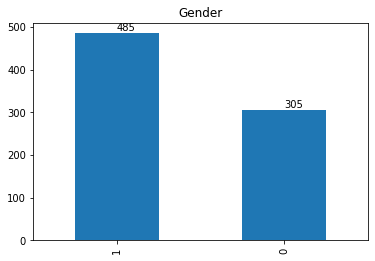

In [33]:
from scipy import stats
import matplotlib.pylab as plt

%matplotlib inline

(timediff_noNA.gender).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.gender.value_counts()):
    plt.text(index, value+5, str(value))
    plt.title("Gender")





Text(0.5, 1.0, 'Histogram of Patient Age when Admitted')

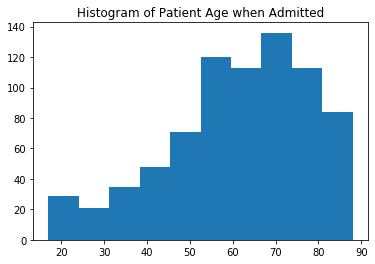

In [34]:
timediff_noNA = timediff_noNA[~(timediff_noNA['age'] <= 0)] 
plt.hist(timediff_noNA.age) # check the weird values are just NA's in age
plt.title("Histogram of Patient Age when Admitted")

# left skew - more older patients

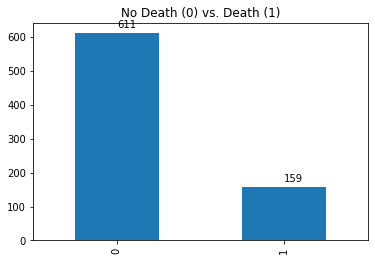

In [35]:
(timediff_noNA.expire_flag).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.expire_flag.value_counts()):
    plt.text(index, value+15, str(value))
    plt.title("No Death (0) vs. Death (1)")



In [36]:
# Get rid of ppl who died

timediff_noNA = timediff_noNA[timediff_noNA['expire_flag']==0]

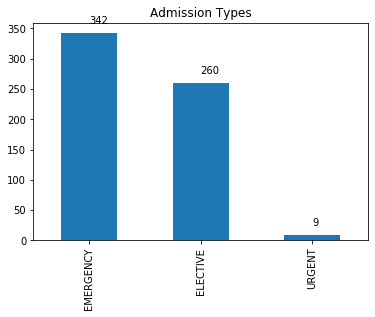

In [37]:
(timediff_noNA.admission_type).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.admission_type.value_counts()):
    plt.text(index, value+15, str(value))
    plt.title("Admission Types")





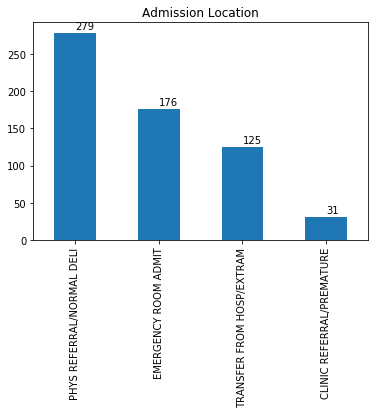

In [38]:
(timediff_noNA.admission_location).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.admission_location.value_counts()):
    plt.text(index, value+5, str(value))
    plt.title("Admission Location")

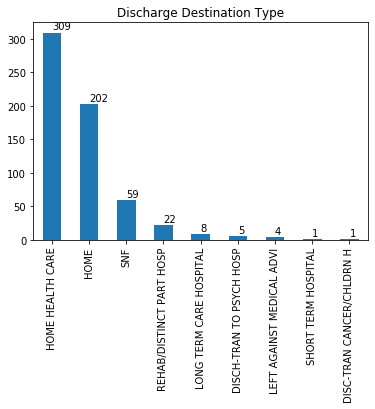

In [39]:
(timediff_noNA.discharge_location).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.discharge_location.value_counts()):
    plt.text(index, value+5, str(value))
    plt.title("Discharge Destination Type")
    

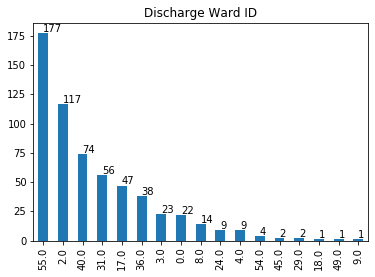

In [40]:
(timediff_noNA.discharge_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.discharge_wardid.value_counts()):
    plt.text(index, value + 1, str(value))
    plt.title("Discharge Ward ID")



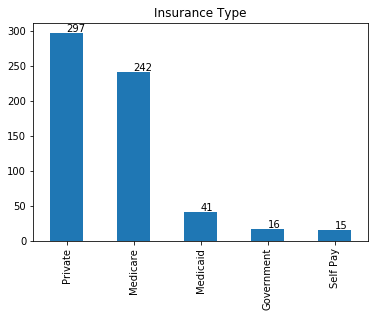

In [41]:
(timediff_noNA.insurance).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.insurance.value_counts()):
    plt.text(index, value+2, str(value))
    plt.title("Insurance Type")



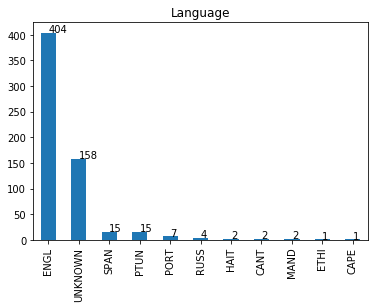

In [42]:
(timediff_noNA.language).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.language.value_counts()):
    plt.text(index, value+1, str(value))
    plt.title("Language")



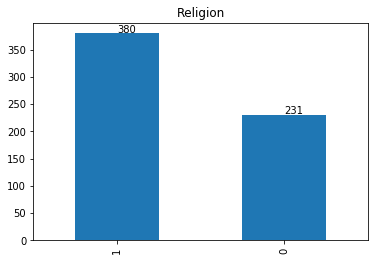

In [43]:
# Would religion possibly influence discharge procedures?

(timediff_noNA.religion).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.religion.value_counts()):
    plt.text(index, value+1, str(value))
    plt.title("Religion")



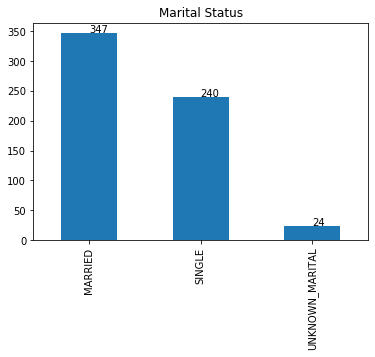

In [44]:
# Do married individuals receive different care than not married? 
# Lack of support system to help them through medical system?

(timediff_noNA.marital_status).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.marital_status.value_counts()):
    plt.text(index, value+1, str(value))
    plt.title("Marital Status")



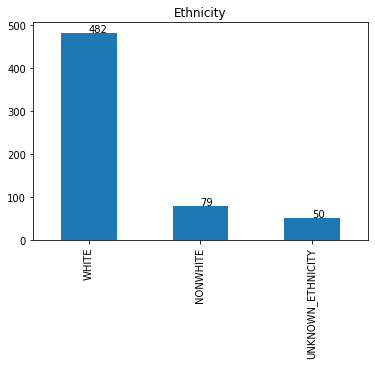

In [45]:
(timediff_noNA.ethnicity).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.ethnicity.value_counts()):
    plt.text(index, value+2, str(value))
    plt.title("Ethnicity")



In [46]:
# for d in timediff_noNA.diagnosis_categories:
#     print(d,": " ,timediff_noNA.diagnosis_categories[d].count())
(timediff_noNA.diagnosis_categories).value_counts()


CARDIOVASCULAR     389
GENERAL_TRAUMA      63
GI                  62
NEUROLOGICAL        50
ONCOLOGY            18
OTHER_DIAGNOSIS     15
RESPIRATORY         10
INFECTIONS           4
Name: diagnosis_categories, dtype: int64

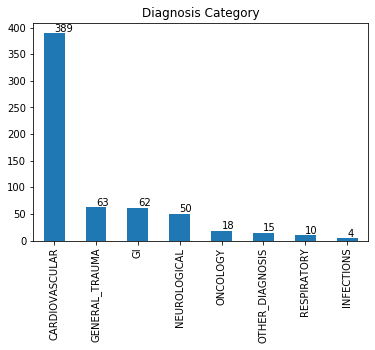

In [47]:
(timediff_noNA.diagnosis_categories).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.diagnosis_categories.value_counts()):
    plt.text(index, value+3, str(value))
    plt.title("Diagnosis Category")

  
    

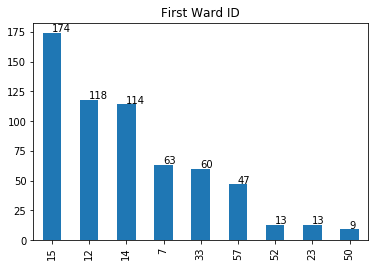

In [48]:
(timediff_noNA.first_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.first_wardid.value_counts()):
    plt.text(index, value+1, str(value))
    plt.title("First Ward ID")



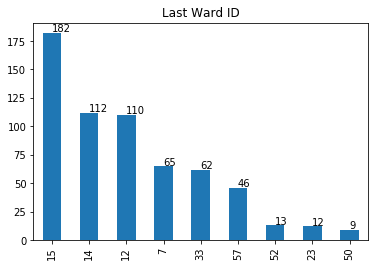

In [49]:
(timediff_noNA.last_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.last_wardid.value_counts()):
    plt.text(index, value+1, str(value))
    plt.title("Last Ward ID")



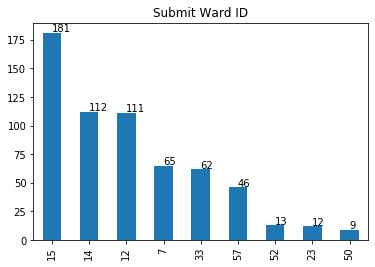

In [50]:
(timediff_noNA.submit_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.submit_wardid.value_counts()):
    plt.text(index, value+1, str(value))
    plt.title("Submit Ward ID")



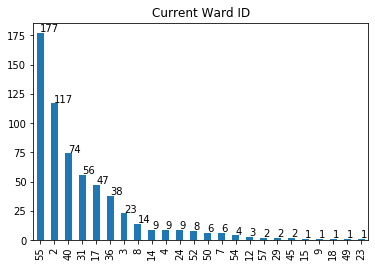

In [51]:
(timediff_noNA.curr_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.curr_wardid.value_counts()):
    plt.text(index, value+1, str(value))
    plt.title("Current Ward ID")



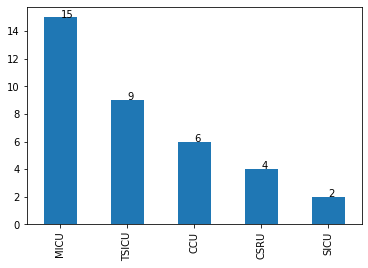

In [52]:
(timediff_noNA.submit_careunit).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.submit_careunit.value_counts()):
    plt.text(index, value, str(value))

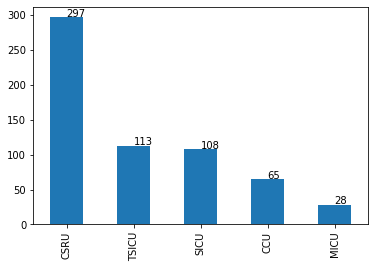

In [53]:
(timediff_noNA.curr_careunit).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.curr_careunit.value_counts()):
    plt.text(index, value+1, str(value))

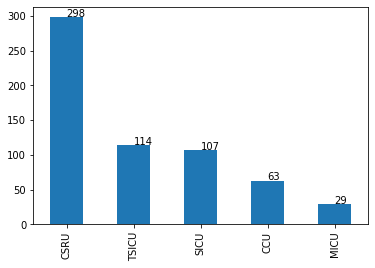

In [54]:
(timediff_noNA.first_careunit).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.first_careunit.value_counts()):
    plt.text(index, value+1, str(value))

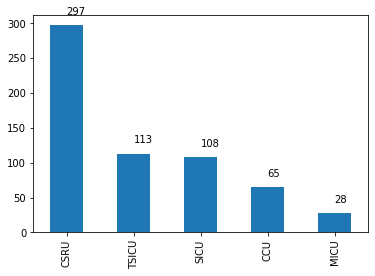

In [55]:
(timediff_noNA.last_careunit).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.last_careunit.value_counts()):
    plt.text(index, value+15, str(value))

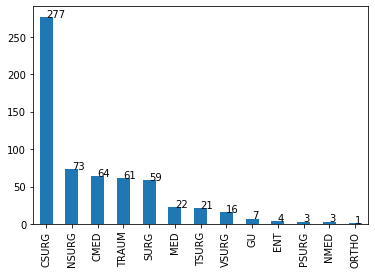

In [56]:
(timediff_noNA.curr_service).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.curr_service.value_counts()):
    plt.text(index, value, str(value))

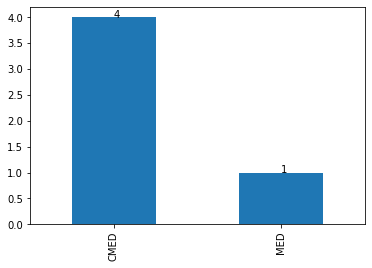

In [57]:
(timediff_noNA.prev_service).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.prev_service.value_counts()):
    plt.text(index, value, str(value))

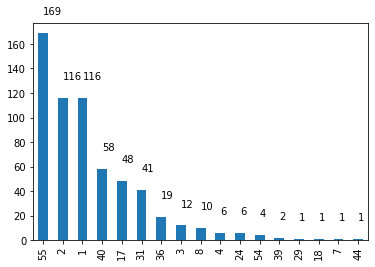

In [58]:
(timediff_noNA.callout_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.callout_wardid.value_counts()):
    plt.text(index, value+15, str(value))

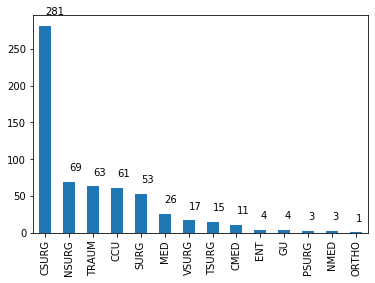

In [59]:
(timediff_noNA.callout_service).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.callout_service.value_counts()):
    plt.text(index, value+15, str(value))

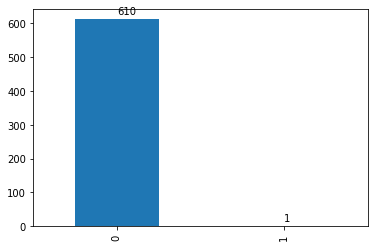

In [60]:
(timediff_noNA.request_cdiff).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.request_cdiff.value_counts()):
    plt.text(index, value+15, str(value))

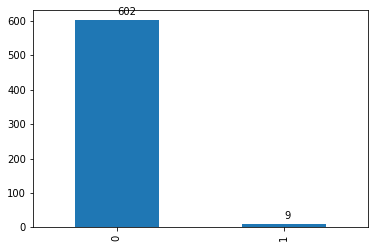

In [61]:
(timediff_noNA.request_mrsa).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.request_mrsa.value_counts()):
    plt.text(index, value+15, str(value))

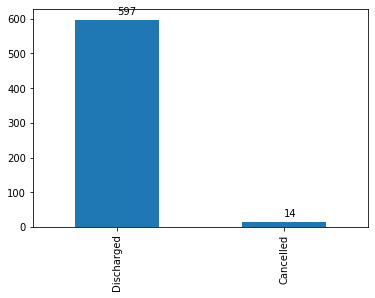

In [62]:
(timediff_noNA.callout_outcome).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.callout_outcome.value_counts()):
    plt.text(index, value+15, str(value))

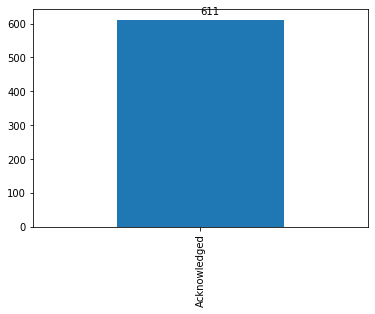

In [63]:
(timediff_noNA.acknowledge_status).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.acknowledge_status.value_counts()):
    plt.text(index, value+15, str(value))

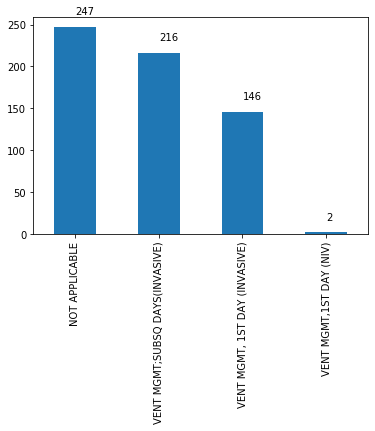

In [64]:
(timediff_noNA.description).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.description.value_counts()):
    plt.text(index, value+15, str(value))

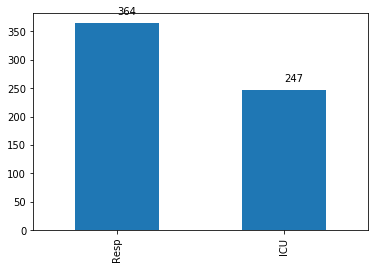

In [65]:
(timediff_noNA.costcenter).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.costcenter.value_counts()):
    plt.text(index, value+15, str(value))

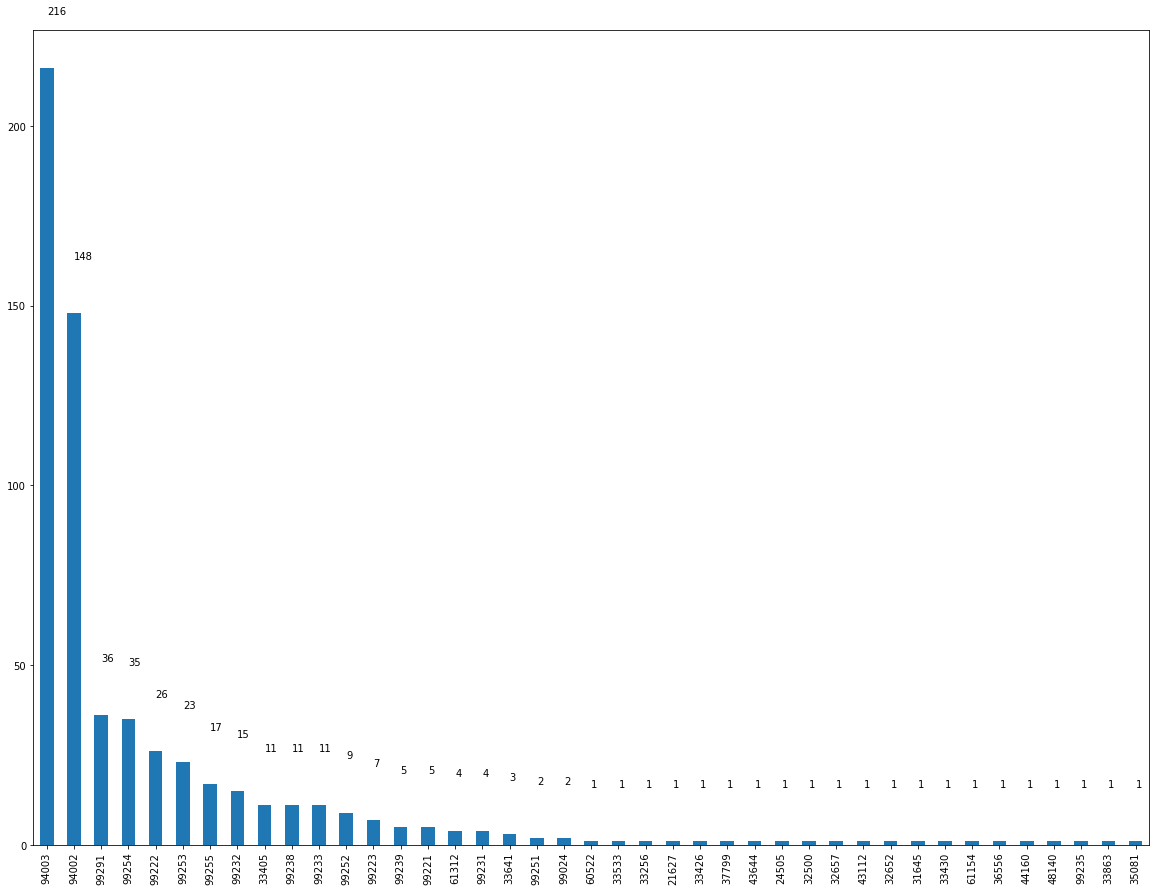

In [66]:
plt.figure(figsize=(20,15))
(timediff_noNA.cpt_cd).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.cpt_cd.value_counts()):
    plt.text(index, value+15, str(value))

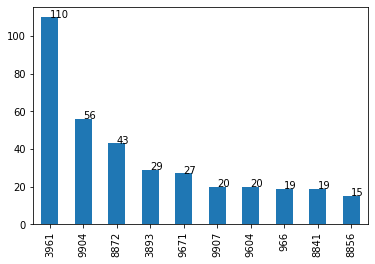

In [67]:
# Only showing top 10
(timediff_noNA.icd9_code).value_counts()[:10].plot(kind='bar')
for index, value in enumerate(timediff_noNA.icd9_code.value_counts()[:10]):
    plt.text(index, value, str(value))
    

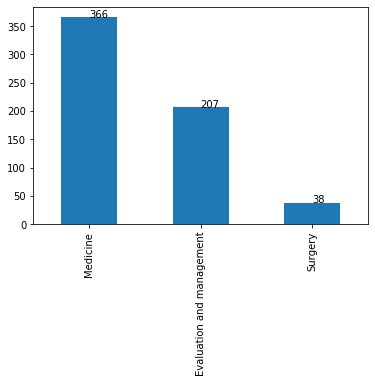

In [68]:
(timediff_noNA.sectionheader).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.sectionheader.value_counts()):
    plt.text(index, value, str(value))

(array([343., 193.,  50.,  15.,   2.,   4.,   2.,   1.,   0.,   1.]),
 array([ 0.407  ,  1.87031,  3.33362,  4.79693,  6.26024,  7.72355,
         9.18686, 10.65017, 12.11348, 13.57679, 15.0401 ]),
 <a list of 10 Patch objects>)

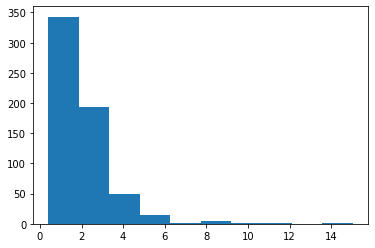

In [69]:
plt.hist(timediff_noNA.los)

(array([102., 178., 163.,  99.,  45.,  13.,   3.,   3.,   1.,   4.]),
 array([ 0.1 ,  2.45,  4.8 ,  7.15,  9.5 , 11.85, 14.2 , 16.55, 18.9 ,
        21.25, 23.6 ]),
 <a list of 10 Patch objects>)

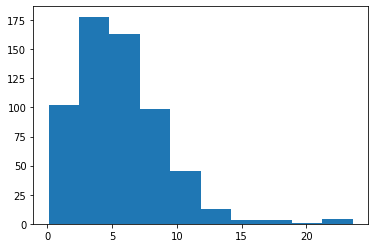

In [70]:
# Histogram of target

plt.hist(timediff_noNA.timediff_hours)

(array([69., 71., 86., 88., 52., 27., 33., 56., 42., 87.]),
 array([ 0.  ,  2.39,  4.78,  7.17,  9.56, 11.95, 14.34, 16.73, 19.12,
        21.51, 23.9 ]),
 <a list of 10 Patch objects>)

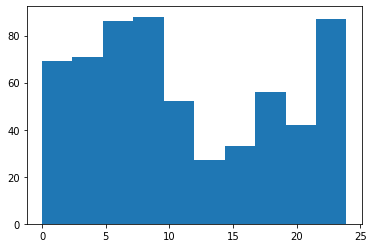

In [71]:
plt.hist(timediff_noNA.admit2disch_hours)

/Users/dereklee/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dereklee/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([30., 55., 50., 29., 15.,  8.,  2.,  6.,  0.,  3.]),
 array([ 0.4,  1.9,  3.4,  4.9,  6.4,  7.9,  9.4, 10.9, 12.4, 13.9, 15.4]),
 <a list of 10 Patch objects>)

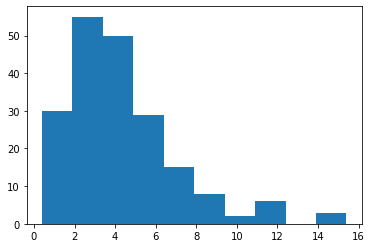

In [72]:
plt.hist(timediff_noNA.edreg2edout_hours)

(array([115., 107.,  78.,  50.,  24.,  26.,  30.,  45.,  52.,  84.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

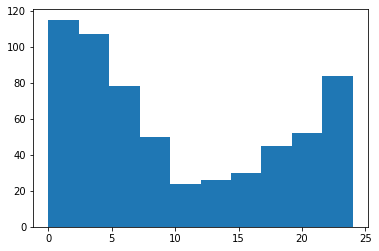

In [73]:
plt.hist(timediff_noNA.in2out_hours)

Text(0.5, 1.0, 'Distribution of ED registration time by Day of Month')

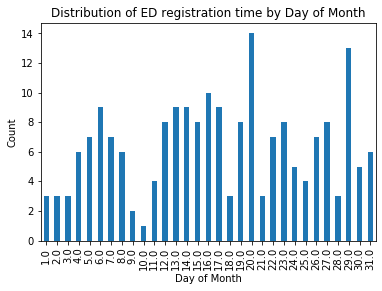

In [74]:
timediff_noNA["edregtime"].groupby(timediff_noNA["edregtime"].dt.day).count().plot(kind="bar")
# data["edregtime"].groupby(data["edregtime"].dt.day).count().plot.hist(bins=12, alpha= 0.5)
# data["edregtime"].groupby(data["edregtime"].dt.day).count().plot.hist()


plt.xlabel("Day of Month")
plt.ylabel("Count")
plt.title("Distribution of ED registration time by Day of Month")

Text(0.5, 1.0, 'Distribution of ED out time by Day of Month')

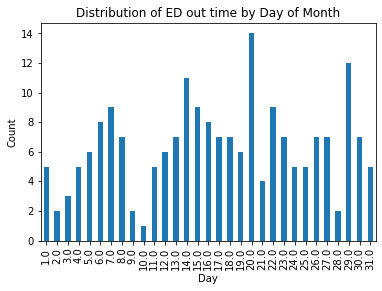

In [75]:
timediff_noNA["edouttime"].groupby(timediff_noNA["edouttime"].dt.day).count().plot(kind="bar")
# data["edouttime"].groupby(data["edouttime"].dt.day).count().plot.hist()
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of ED out time by Day of Month")

Text(0.5, 1.0, 'Distribution of admit time by Day of Month')

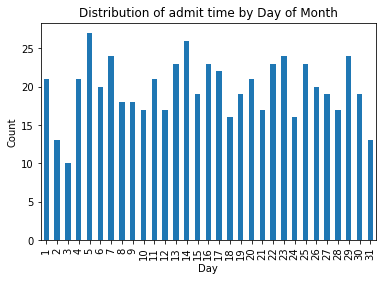

In [76]:
timediff_noNA["admittime"].groupby(timediff_noNA["admittime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of admit time by Day of Month")

Text(0.5, 1.0, 'Distribution of discharge time by Day of Month')

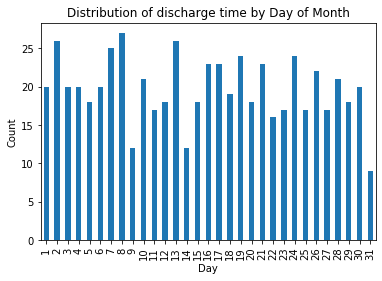

In [77]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of discharge time by Day of Month")

We may want to create a new variable putting days into week in month (days 1-7, 8-14, 15-21, 22-31)

Text(0.5, 1.0, 'Distribution of discharge time by Month')

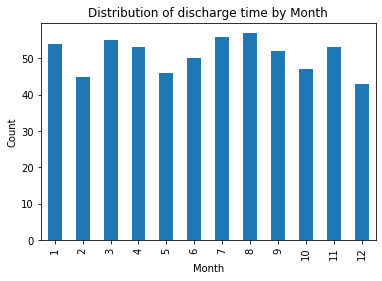

In [78]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.month).count().plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of discharge time by Month")

Text(0.5, 1.0, 'Distribution of discharge time by hour')

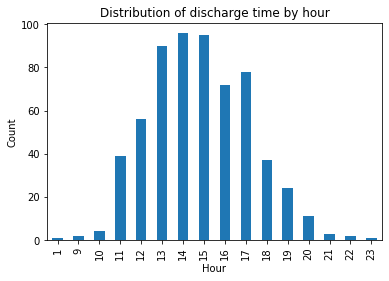

In [79]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of discharge time by hour")

Text(0.5, 1.0, 'Distribution of create time by hour')

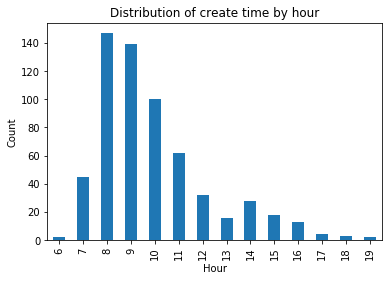

In [80]:
timediff_noNA["createtime"].groupby(timediff_noNA["createtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of create time by hour")

Text(0.5, 1.0, 'Distribution of update time by hour')

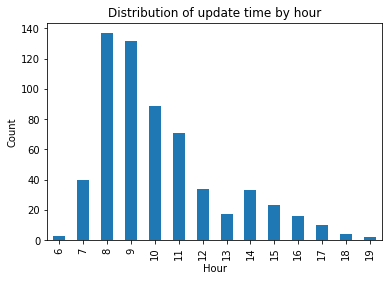

In [81]:
timediff_noNA["updatetime"].groupby(timediff_noNA["updatetime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of update time by hour")

Text(0.5, 1.0, 'Distribution of acknowledge time by hour')

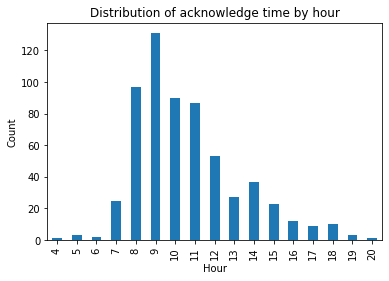

In [82]:
timediff_noNA["acknowledgetime"].groupby(timediff_noNA["acknowledgetime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of acknowledge time by hour")

Text(0.5, 1.0, 'Distribution of outcome time by hour')

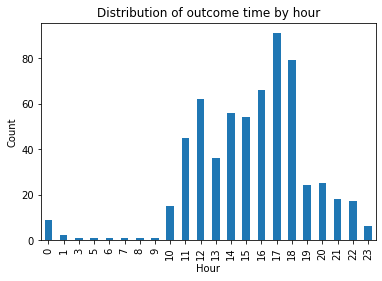

In [83]:
timediff_noNA["outcometime"].groupby(timediff_noNA["outcometime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of outcome time by hour")

Text(0.5, 1.0, 'Distribution of in time by hour')

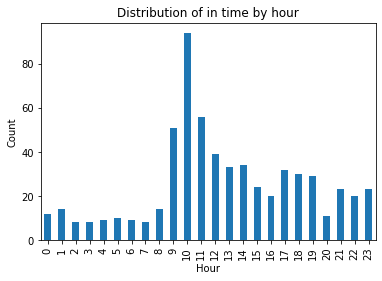

In [84]:
timediff_noNA["intime"].groupby(timediff_noNA["intime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of in time by hour")

Text(0.5, 1.0, 'Distribution of out time by hour')

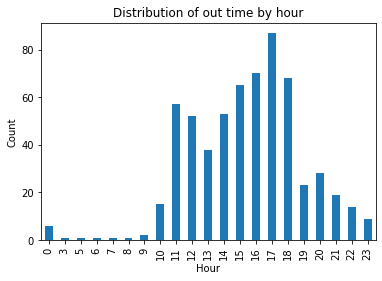

In [85]:
timediff_noNA["outtime"].groupby(timediff_noNA["outtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of out time by hour")

Text(0.5, 1.0, 'Distribution of transfer time by hour')

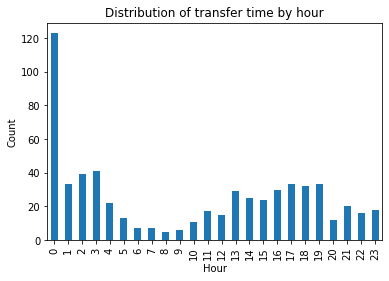

In [86]:
timediff_noNA["transfertime"].groupby(timediff_noNA["transfertime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of transfer time by hour")

The above plots have shown us that there may be some trends with different time events.

When examining the days of the month that certain events happened, we see a lot of visits happen on the same day, meaning that the highest volume of `edregtime` and `edouttime` fall on the same days. In this dataset, they seem to fall overwhelmingly on the 7th, 13th, 14th, 17th, 20th, 22nd, and 29th of the month. The high turnover in emergency departments makes sense. On the other hand, `admittime` and `dischtime` don't necessarily fall on the same day. These are probably describing hospital stays over the course of several days.

Discharge times (`dischtime`) seem to most commonly occur during the afternoon hours from 1-5 pm. `deathtime` seems to be most common at 1 am and between 11 am and 12 pm. There may be some correlation there with how often rounds are made. 

`createtime` and `updatetime` describe call outs, or more specifically, the record of when patients were ready for discharge (called out), and the actual time of their discharge (or more generally, their outcome), as described by `outcometime`. `createtime`, `updatetime`, and `acknowledgetime` occur most frequently from 8 am - 10 am. `outcometime` occurs most frequently from 4 pm to 6 pm. This pattern warrants some further exploration to see truly how long each patient has to wait from when they are ready for discharge to when they are actually discharged.

The services table describes hospital services that patients were under during their hospital stay. `transfertime` describes the time when a transfer occured. The most common transfer time was overwhelmingly 12 am, followed by 1 pm, 3 am and 5 pm (equally common), and 7 pm.  





In [87]:
timediff_noNA.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime',
       'diagnosis', 'hospital_expire_flag', 'has_chartevents_data',
       'submit_wardid', 'submit_careunit', 'curr_wardid', 'curr_careunit',
       'callout_wardid', 'callout_service', 'request_cdiff', 'request_mrsa',
       'callout_status', 'callout_outcome', 'discharge_wardid',
       'acknowledge_status', 'createtime', 'updatetime', 'acknowledgetime',
       'outcometime', 'first_careunit', 'last_careunit', 'first_wardid',
       'last_wardid', 'intime', 'outtime', 'los', 'costcenter', 'cpt_cd',
       'cpt_number', 'cpt_suffix', 'sectionheader', 'subsectionheader',
       'description', 'transfertime', 'prev_service', 'curr_service',
       'seq_num', 'icd9_code', 'timediff', 't

In [88]:
timediff_noNA['description'].unique() # only a few categories for the description so it's not really free text


array(['VENT MGMT;SUBSQ DAYS(INVASIVE)', 'VENT MGMT, 1ST DAY (INVASIVE)',
       'NOT APPLICABLE', 'VENT MGMT,1ST DAY (NIV)'], dtype=object)

In [89]:
timediff_noNA['admission_location'].unique()

array(['PHYS REFERRAL/NORMAL DELI', 'TRANSFER FROM HOSP/EXTRAM',
       'EMERGENCY ROOM ADMIT', 'CLINIC REFERRAL/PREMATURE'], dtype=object)

In [90]:
timediff_noNA['admission_type'].unique()

array(['ELECTIVE', 'EMERGENCY', 'URGENT'], dtype=object)

In [91]:
timediff_noNA['discharge_location'].unique()

array(['HOME HEALTH CARE', 'HOME', 'DISCH-TRAN TO PSYCH HOSP', 'SNF',
       'REHAB/DISTINCT PART HOSP', 'LONG TERM CARE HOSPITAL',
       'LEFT AGAINST MEDICAL ADVI', 'DISC-TRAN CANCER/CHLDRN H',
       'SHORT TERM HOSPITAL'], dtype=object)

Now we want to make a correlation matrix of our data

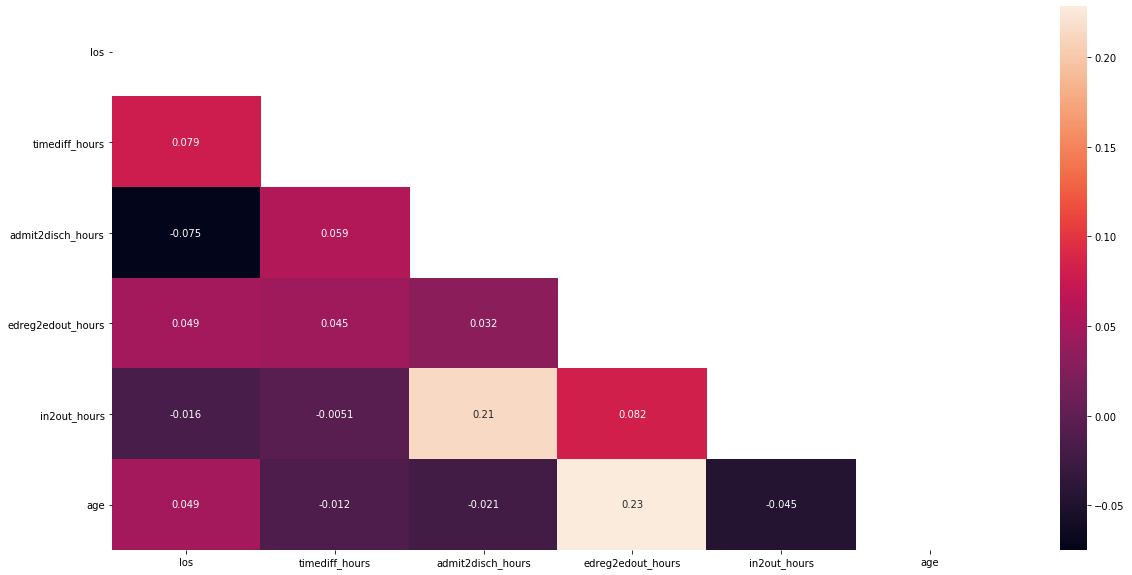

In [92]:
import seaborn as sns
continuous = timediff_noNA[["los","timediff_hours","admit2disch_hours","edreg2edout_hours", "in2out_hours","age"]]
a4_dims = (20, 10)
corrMatrix=continuous.corr()
mask_ut=np.triu(np.ones(corrMatrix.shape)).astype(np.bool)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corrMatrix,mask=mask_ut,annot=True)
plt.show()

Evaluating the correlation matrix of the continuous variable, there is no strong correlation between any pairwise combination of the variables.

##### Check for missing values

In [93]:
timediff_noNA.columns[timediff_noNA.isnull().any()]

Index(['dod', 'dod_hosp', 'dod_ssn', 'deathtime', 'edregtime', 'edouttime',
       'submit_careunit', 'discharge_wardid', 'cpt_suffix', 'prev_service',
       'deathmonth', 'edreg2edout_hours'],
      dtype='object')

In [94]:
timediff_noNA['dod'].isna().sum() # 611 no dod because they didn't die
# timediff_noNA['language'].isna().sum() # 0 unknown language
# timediff_noNA['marital_status'].isna().sum() # 0 unknown marital status
# timediff_noNA['edregtime'].isna().sum() # 413 unknown edregtime, edouttime - likely didn't visit ED
timediff_noNA['edouttime'].isna().sum()  # 413 unknown edouttime - likely didn't visit ED
timediff_noNA['submit_careunit'].isna().sum() # 575 was not from ICU
# timediff_noNA['discharge_wardid'].isna().sum() # 14 unknown wards to which the patient was discharged.
# timediff_noNA['cpt_suffix'].isna().sum() # 611 unknown Text element of the Current Procedural Terminology (CPT)
# timediff_noNA['description'].isna().sum() # 0 missing description of CPT
# timediff_noNA['prev_service'].isna().sum() # 606 missing previous service type
# timediff_noNA['edreg2edout_hours'].isna().sum() # 413 unknown edreg2edout_hours b/c didn't visit ED 
# timediff_noNA['timediff_hours'].isna().sum() # 0 missing target variable 




575

In [95]:
timediff_noNA[["edregtime","admission_type"]]

,edregtime,admission_type
subject_id,,
325,NaT,ELECTIVE
485,NaT,EMERGENCY
583,NaT,EMERGENCY
756,NaT,URGENT
841,NaT,ELECTIVE
...,...,...
98070,2168-02-18 21:51:00,EMERGENCY
98094,2122-12-29 08:35:00,EMERGENCY
99362,2152-10-31 21:40:00,EMERGENCY


### ANOVA

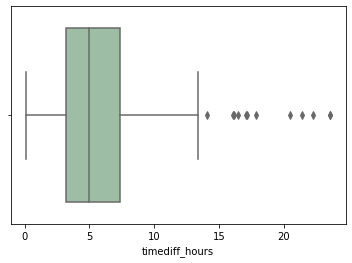

In [96]:
ax = sns.boxplot(timediff_noNA['timediff_hours'], data=timediff_noNA, color='#99c2a2')


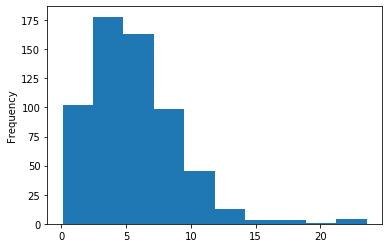

In [97]:
(timediff_noNA['timediff_hours']).plot.hist()

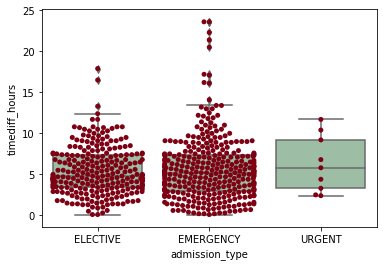

In [98]:
ax = sns.boxplot(x='admission_type', y=timediff_noNA['timediff_hours'], data=timediff_noNA, color='#99c2a2')
ax = sns.swarmplot(x="admission_type", y=timediff_noNA['timediff_hours'], data=timediff_noNA, color='#7d0013')
plt.show()



In [99]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


model = ols('timediff_hours ~ C(admission_type)', data=timediff_noNA).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(admission_type),14.767841,2.0,0.623008,0.536671
Residual,7206.050032,608.0,NaN,NaN


In [100]:
import scikit_posthocs as sp
sp.posthoc_ttest(timediff_noNA, val_col='timediff_hours', group_col='admission_type', p_adjust='holm')

# no significant difference

,ELECTIVE,EMERGENCY,URGENT
ELECTIVE,1.0,1.0,1.0
EMERGENCY,1.0,1.0,1.0
URGENT,1.0,1.0,1.0


In [101]:
timediff_noNA[timediff_noNA['admission_type']=="EMERGENCY"].shape

(342, 67)

In [102]:
timediff_noNA[timediff_noNA['admission_type']=="ELECTIVE"].shape

(260, 67)

In [103]:
timediff_noNA[timediff_noNA['admission_type']=="URGENT"].shape

(9, 67)

## Refining dataset

In [104]:
(timediff_noNA.columns)

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime',
       'diagnosis', 'hospital_expire_flag', 'has_chartevents_data',
       'submit_wardid', 'submit_careunit', 'curr_wardid', 'curr_careunit',
       'callout_wardid', 'callout_service', 'request_cdiff', 'request_mrsa',
       'callout_status', 'callout_outcome', 'discharge_wardid',
       'acknowledge_status', 'createtime', 'updatetime', 'acknowledgetime',
       'outcometime', 'first_careunit', 'last_careunit', 'first_wardid',
       'last_wardid', 'intime', 'outtime', 'los', 'costcenter', 'cpt_cd',
       'cpt_number', 'cpt_suffix', 'sectionheader', 'subsectionheader',
       'description', 'transfertime', 'prev_service', 'curr_service',
       'seq_num', 'icd9_code', 'timediff', 't

In [105]:
pre_dummify = timediff_noNA.drop(columns=['admittime','createtime',
                                         'cpt_suffix','diagnosis',
                                         'dischtime', 'deathtime', 
                                         'acknowledgetime',
                                         'dob','dod','dod_hosp',
                                        'dod_ssn','edouttime',
                                         'edregtime','edreg2edout_hours','icd9_code','intime',
                                         'outcometime',
                                         'outtime', 'prev_service',
                                        'row_id', 'seq_num','transfertime',
                                         'updatetime','timediff'])

In [106]:
simple_dummies_cols = ['admission_type','admission_location','discharge_location','insurance',
                                                                                 'language',
                                                                                 'marital_status',
                                                                                 'ethnicity', 'costcenter',
                                                                                  'diagnosis_categories']

In [107]:


simpledataset = timediff_noNA[['in2out_hours',
 'admit2disch_hours',
 'age','gender','admission_type',
'admission_location','discharge_location','insurance',
'language','religion',
'marital_status',
'ethnicity', 'costcenter','los',
'diagnosis_categories', 'timediff_hours']]

In [108]:
simpledf_with_dummies = pd.get_dummies(simpledataset, prefix=simple_dummies_cols, columns=simple_dummies_cols)

In [ ]:
# remaining columns (check these dummy columns are still remaining):
# removed religion since dummified previously
dummies_cols = ['gender','admission_type','admission_location','discharge_location','insurance',
                                                                                 'language',
                                                                                 'marital_status',
                                                                                 'ethnicity',
                                                                                 'submit_careunit',
                                                                                 'curr_wardid',
                                                                                 'curr_careunit',
                                                                                 'callout_wardid',
                                                                                 'callout_service',
                                                                                 'callout_outcome',
                                                                                 'callout_status',
                                                                                 'discharge_wardid',
                                                                                 'acknowledge_status',
                                                                                 'first_careunit',
                                                                                 'last_careunit',
                                                                                 'first_wardid',
                                                                                 'last_wardid',
                                                                                 'costcenter',
                                                                                 'cpt_cd',
                                                                                 'cpt_number',
                                                                                 'cpt_suffix',
                                                                                 'sectionheader',
                                                                                 'subsectionheader',
                                                                                 'description',
                                                                                 'prev_service',
                                                                                 'curr_service',
                                                                                 'diagnosis_categories']


# Uncomment when finalized the df_with_dummies (first try using the simple dataset)
# df_with_dummies = pd.get_dummies(timediff_noNA, prefix=dummies_cols, columns=dummies_cols)





In [ ]:
df_with_dummies.head()

In [ ]:
# drop unnecessary columns in final dataset:

# final_df = df_with_dummies.drop(columns=['admittime','createtime','diagnosis','dischtime', 'deathtime', 'acknowledgetime',
#                                          'dob','dod','dod_hosp',
#                                         'dod_ssn','edouttime','edregtime','intime','outcometime','outtime',
#                                         'row_id','transfertime','updatetime','timediff'])


# final_df = df_with_dummies.drop(columns=['admittime','createtime',
#                                          'cpt_suffix','diagnosis',
#                                          'dischtime', 'deathtime', 
#                                          'acknowledgetime',
#                                          'dob','dod','dod_hosp',
#                                         'dod_ssn','edouttime',
#                                          'edregtime','intime',
#                                          'outcometime',
#                                          'outtime', 'prev_service',
#                                         'row_id','transfertime',
#                                          'updatetime','timediff'])




In [ ]:
sorted(final_df.columns)

## Final Dataset:

In [109]:
simpledf_with_dummies.head()

,in2out_hours,admit2disch_hours,age,gender,religion,los,timediff_hours,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,admission_location_CLINIC REFERRAL/PREMATURE,admission_location_EMERGENCY ROOM ADMIT,admission_location_PHYS REFERRAL/NORMAL DELI,admission_location_TRANSFER FROM HOSP/EXTRAM,discharge_location_DISC-TRAN CANCER/CHLDRN H,discharge_location_DISCH-TRAN TO PSYCH HOSP,discharge_location_HOME,discharge_location_HOME HEALTH CARE,discharge_location_LEFT AGAINST MEDICAL ADVI,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,language_CANT,language_CAPE,language_ENGL,language_ETHI,language_HAIT,language_MAND,language_PORT,language_PTUN,language_RUSS,language_SPAN,language_UNKNOWN,marital_status_MARRIED,marital_status_SINGLE,marital_status_UNKNOWN_MARITAL,ethnicity_NONWHITE,ethnicity_UNKNOWN_ETHNICITY,ethnicity_WHITE,costcenter_ICU,costcenter_Resp,diagnosis_categories_CARDIOVASCULAR,diagnosis_categories_GENERAL_TRAUMA,diagnosis_categories_GI,diagnosis_categories_INFECTIONS,diagnosis_categories_NEUROLOGICAL,diagnosis_categories_ONCOLOGY,diagnosis_categories_OTHER_DIAGNOSIS,diagnosis_categories_RESPIRATORY
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
325,21.7,6.4,57,0,0,2.9029,8.5,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0
485,1.8,21.9,65,0,1,3.0771,6.5,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
583,23.3,19.5,63,1,1,0.9700,2.5,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
756,5.9,9.4,72,0,1,1.2439,10.4,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
841,0.0,1.7,43,0,1,2.0020,2.4,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0


In [110]:
final_df = simpledf_with_dummies

In [111]:
# using the hours column may help us avoid converting to cyclical time features esp if we don't care about cyclical

y = final_df.timediff_hours

X = final_df.loc[:, final_df.columns != 'timediff_hours']


In [112]:
final_df.to_csv('/Users/dereklee/biostat-masters-thesis/final_df.csv')

# Random Forest

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
X_train.head()

,in2out_hours,admit2disch_hours,age,gender,religion,los,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,admission_location_CLINIC REFERRAL/PREMATURE,admission_location_EMERGENCY ROOM ADMIT,admission_location_PHYS REFERRAL/NORMAL DELI,admission_location_TRANSFER FROM HOSP/EXTRAM,discharge_location_DISC-TRAN CANCER/CHLDRN H,discharge_location_DISCH-TRAN TO PSYCH HOSP,discharge_location_HOME,discharge_location_HOME HEALTH CARE,discharge_location_LEFT AGAINST MEDICAL ADVI,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,language_CANT,language_CAPE,language_ENGL,language_ETHI,language_HAIT,language_MAND,language_PORT,language_PTUN,language_RUSS,language_SPAN,language_UNKNOWN,marital_status_MARRIED,marital_status_SINGLE,marital_status_UNKNOWN_MARITAL,ethnicity_NONWHITE,ethnicity_UNKNOWN_ETHNICITY,ethnicity_WHITE,costcenter_ICU,costcenter_Resp,diagnosis_categories_CARDIOVASCULAR,diagnosis_categories_GENERAL_TRAUMA,diagnosis_categories_GI,diagnosis_categories_INFECTIONS,diagnosis_categories_NEUROLOGICAL,diagnosis_categories_ONCOLOGY,diagnosis_categories_OTHER_DIAGNOSIS,diagnosis_categories_RESPIRATORY
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
79687,9.1,2.0,72,0,1,2.3780,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0
27272,1.6,3.4,69,1,1,2.0687,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
28232,23.3,0.4,47,1,1,0.9701,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
13176,5.2,23.5,66,1,1,2.2146,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
17935,20.0,17.6,47,1,0,3.8326,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0


In [115]:
for d in X_train:
    print(d,": " ,X_train[d].dtype)

in2out_hours :  float64
admit2disch_hours :  float64
age :  int64
gender :  int64
religion :  int64
los :  float64
admission_type_ELECTIVE :  uint8
admission_type_EMERGENCY :  uint8
admission_type_URGENT :  uint8
admission_location_CLINIC REFERRAL/PREMATURE :  uint8
admission_location_EMERGENCY ROOM ADMIT :  uint8
admission_location_PHYS REFERRAL/NORMAL DELI :  uint8
admission_location_TRANSFER FROM HOSP/EXTRAM :  uint8
discharge_location_DISC-TRAN CANCER/CHLDRN H :  uint8
discharge_location_DISCH-TRAN TO PSYCH HOSP :  uint8
discharge_location_HOME :  uint8
discharge_location_HOME HEALTH CARE :  uint8
discharge_location_LEFT AGAINST MEDICAL ADVI :  uint8
discharge_location_LONG TERM CARE HOSPITAL :  uint8
discharge_location_REHAB/DISTINCT PART HOSP :  uint8
discharge_location_SHORT TERM HOSPITAL :  uint8
discharge_location_SNF :  uint8
insurance_Government :  uint8
insurance_Medicaid :  uint8
insurance_Medicare :  uint8
insurance_Private :  uint8
insurance_Self Pay :  uint8
language_CA

In [116]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [117]:
from sklearn.ensemble import RandomForestRegressor

In [118]:
import sklearn
sklearn.show_versions()


System:
    python: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46)  [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
executable: /Users/dereklee/anaconda3/bin/python
   machine: Darwin-19.6.0-x86_64-i386-64bit

Python dependencies:
          pip: 19.1.1
   setuptools: 41.0.1
      sklearn: 0.23.2
        numpy: 1.18.5
        scipy: 1.4.1
       Cython: 0.29.7
       pandas: 0.25.3
   matplotlib: 3.1.3
       joblib: 0.14.1
threadpoolctl: 2.1.0

Built with OpenMP: True


In [119]:
# Tried w/ 20 trees

regressor = RandomForestRegressor(n_estimators=100, random_state=42) # n_estimators is no. of trees
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# splits using residual sum of squares (https://math.usu.edu/adele/randomforests/ovronnaz.pdf)

In [120]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


# You can play around with the number of trees and other parameters to see 
# if you can get better results




Mean Absolute Error: 2.4502113821138214
Mean Squared Error: 11.776283235772361
Root Mean Squared Error: 3.4316589626261464


# Results:  

### 100 Trees:  
Mean Absolute Error: 2.5036898734177213  
Mean Squared Error: 11.569551765822784  
Root Mean Squared Error: 3.401404381402303  

### 50 Trees:  
Mean Absolute Error: 2.489113924050633  
Mean Squared Error: 11.566727696202532   
Root Mean Squared Error: 3.400989223182357  

### 20 Trees:  
Mean Absolute Error: 2.516107594936709  
Mean Squared Error: 11.806399841772153  
Root Mean Squared Error: 3.4360442141759693  

In [121]:
# print('Prediction: %d' % regressor.predict(X_test[0]))
predictions = []

for i in X_test:
    print(i)
    break

# regressor.predict([X_test[0]])


[-0.82569397 -0.19421054  0.11391559 -1.31387099  0.81579961  0.74233539
  1.17989697 -1.14100254 -0.12909944 -0.24200895 -0.64699664  1.10371274
 -0.49807815 -0.04531433 -0.10174462 -0.6984303   0.97171143 -0.09090909
 -0.12063588 -0.19569842  0.         -0.30687197 -0.15185782 -0.28221626
 -0.8123201   1.04185896 -0.16543404 -0.04531433 -0.04531433  0.67902713
 -0.04531433 -0.04531433 -0.04531433 -0.1115712  -0.12909944 -0.07864838
 -0.15877684 -0.57104024 -1.12216722  1.22579121 -0.21205631  2.67083008
 -0.3108524  -1.93335565 -0.84753163  0.84753163  0.77798661 -0.34905455
 -0.34534918 -0.07864838 -0.30285738 -0.17807996 -0.15877684 -0.12909944]


In [122]:
y_test.iloc[1]

5.6

In [123]:
np.mean(y_test)

5.55040650406504

In [124]:
regressor.score(X_test,y_test)

0.06812072631431365

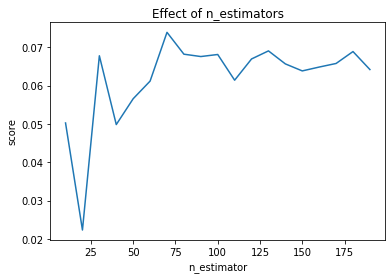

In [125]:
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    regressor.set_params(n_estimators=n)
    regressor.fit(X_train, y_train)
    scores.append(regressor.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [126]:
scores

[0.05027001703042877,
 0.022362765002050145,
 0.06778813958256624,
 0.04985369414767293,
 0.05658915850015056,
 0.061183632804218124,
 0.07389762516976583,
 0.06820121255012102,
 0.06758700977657262,
 0.06812072631431365,
 0.06142136548250543,
 0.06695711469788068,
 0.06906023601490885,
 0.06566988999978729,
 0.06384169085935998,
 0.06484572260239219,
 0.06578053093628355,
 0.06888654656080329,
 0.0641964734881122]

Below code is different one that allows feature importance:  
Documentation seems to show DecisionTreeRegressor is an attribute of RandomForestRegressor:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# from matplotlib import pyplot
# # define dataset
# # X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# # define the model
# model = DecisionTreeRegressor()
# # fit the model
# model.fit(X_train, y_train)
# # get importance
# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

# Linear Regression

In [127]:
from sklearn.linear_model import LinearRegression

In [128]:
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X,y)

LinearRegression()

In [129]:
linear_model.score(X,y)

0.08869414023219169

In [130]:
import statsmodels.api as sm

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         timediff_hours   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.222
Date:                Mon, 01 Feb 2021   Prob (F-statistic):              0.158
Time:                        23:41:28   Log-Likelihood:                -1593.1
No. Observations:                 611   AIC:                             3278.
Df Residuals:                     565   BIC:                             3481.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

/Users/dereklee/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [131]:
y_pred_lm = linear_model.predict(X_test)

In [132]:
print('Mean Absolute Error Linear Reg:', metrics.mean_absolute_error(y_test, y_pred_lm))
print('Mean Squared Error Linear Reg:', metrics.mean_squared_error(y_test, y_pred_lm))
print('Root Mean Squared Error Linear Reg:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lm)))

Mean Absolute Error Linear Reg: 3.725037151519765
Mean Squared Error Linear Reg: 55.619185723622515
Root Mean Squared Error Linear Reg: 7.457827144927839


# XGBoost

In [133]:
from xgboost import XGBClassifier

xgbmodel = XGBClassifier()
xgbmodel.fit(X_train, y_train)

/Users/dereklee/anaconda3/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [139]:
# make predictions for test data
y_pred_xgb = xgbmodel.predict(X_test)
predictions_xgb = [round(value) for value in y_pred_xgb ]

mae_xgb = metrics.mean_absolute_error(y_test, predictions_xgb)
print("Mean Absolute Error XGBoost: ", mae_xgb)

Mean Absolute Error XGBoost:  3.407317073170732


In [141]:
metrics.explained_variance_score(predictions_xgb, y_test)

-1.5038002413441003

# MLP Regressor

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

In [ ]:
linear_model.predict(y_train)

In [ ]:
linear_model.layers[1].kernel

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    X_train, y_train, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# MLP DNN

In [204]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [205]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

NameError: name 'normalizer' is not defined

In [ ]:
%%time
history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

In [ ]:
plot_loss(history)


In [ ]:
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(
    X_test,
    y_test, verbose=0)

In [ ]:
test_results['dnn_model']